## Trigger word rnn model

This notebook is dedicated to developing the rnn model to support this trigger word detection task. The rnn model being implemented for this task consists of a conv1D step to make the input_size=(1,1375,#filters) including dropout and batch normalization, and a multilayered rnn consisting of two GRU cells and dropout. All dropout has a keep_prob=0.8.

In order the show an example of using this model, I will be using the trained model to predict where a trigger word is said in an input and compare that vector to the actual vector of when the trigger word is said.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import latex
import spacy
import math
import IPython
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
np.random.seed(10)
import keras.backend as k

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Loading data
X_data = np.load("../../data/trigger_word/data/x.npy")
y_data = np.load("../../data/trigger_word/data/y.npy")

In [7]:
X_data.shape = (1000,1402,118)
y_data.shape = (1000,1375)

In [8]:
# Training data will be first 10 recordings, and these are unshuffled sets of training ex.
X_train = X_data[10:] # unshuffled
y_train = y_data[10:]
X_test = X_data[:10]
y_test = y_data[:10]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(990, 1402, 118)
(990, 1375)
(10, 1402, 118)
(10, 1375)


In [9]:
# Placeholder functions for model input
def get_placeholders():
    X = tf.placeholder(tf.float32, shape=[None,1402,118], name='X')
    y = tf.placeholder(tf.float32, shape=[None,1375], name='Y')
    return X,y

In [10]:
# Forward prop step consisting of conv 1d, multilayered rnn, and dropout usage
def rnn_cell(the_input):
    # Conv 1D step:
    Z = tf.layers.conv1d(the_input,filters=196,kernel_size=28,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn = tf.layers.batch_normalization(Z)
    A = tf.nn.relu(Bn)
    D = tf.nn.dropout(A,keep_prob=0.8)
    
    # Multilayered GRU units with dropout:
    cell1 = tf.nn.rnn_cell.GRUCell(128,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1,output_keep_prob=0.8)
    cell2 = tf.nn.rnn_cell.GRUCell(128,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    cell2 = tf.nn.rnn_cell.DropoutWrapper(cell2,output_keep_prob=0.8)
    
    multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1,cell2]) # multilayered cell
    outputs,curr_state = tf.nn.dynamic_rnn(multi_cell,inputs=D,dtype=tf.float32)
    
    flats = tf.map_fn(lambda x: tf.layers.flatten(x),outputs)
    out = tf.map_fn(lambda x: tf.layers.dense(x,1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0),reuse=tf.AUTO_REUSE),flats)
    out = tf.reshape(out,[1,1375])
    #flats = [tf.layers.flatten(out) for out in outputs] # - for eager_execution
    #out = [tf.layers.dense(flat,1,activation=None,kernel_initializer=tf.contrib.layers.xavier_initializer(),reuse=tf.AUTO_REUSE) for flat in flats]
    
    return out

In [11]:
# Cost function, uses sigmoid cross entropy with logits to compare the predictions at each 1375 step
def cost_function(logits,y):
    return tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=logits))

In [12]:
# Sigmoid prediction for a given vector of logits, returns both a sigmoid activation output and discrete classes - 0,1
def prediction(logits):
    sigmoid_out = tf.nn.sigmoid(logits)
    desc_out = tf.to_int32(sigmoid_out > 0.5)
    return sigmoid_out,desc_out

In [13]:
# Testing forward prop and cost function
# Example cost is large because sigmoid cross entropy is being used on 1375 epochs per training example
ax = X_train[0]
ax.shape = (1,1402, 118)
ay = y_train[0]
ay.shape = (1,1375)
tf.reset_default_graph()
x,y = get_placeholders()
out = rnn_cell(x)
cost = cost_function(out,y)
pred = prediction(out)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    aout = sess.run(out,feed_dict={x:ax,y:ay})
    acost = sess.run(cost,feed_dict={x:ax,y:ay})
    apred,adesc_pred = sess.run(pred,feed_dict={x:ax,y:ay})
    print("output shape:",aout.shape)
    print("example cost:",acost)
    print("example predictions:",apred)
    print("descrete predictions:",adesc_pred)

output shape: (1, 1375)
example cost: 1196.4111
example predictions: [[0.4194148  0.44809484 0.39459923 ... 0.55335313 0.5448271  0.5622999 ]]
descrete predictions: [[0 0 0 ... 1 1 1]]


In [14]:
# Model for trigger word detection using stochastic gradient descent w/ gradient clipping
def model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=True,print_each=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    
    x,y = get_placeholders()
    logits = rnn_cell(x)
    cost = cost_function(logits,y)
    pred = prediction(logits) # get binary predictions and sigmoid activation output
    
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    grads, variables = zip(*optimizer.compute_gradients(cost))
    grads, _ = tf.clip_by_global_norm(grads, 5.0) # gradient clipping
    optimizer = optimizer.apply_gradients(zip(grads, variables))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() # to save/load model
    with tf.Session() as sess:
        if retrain:
            saver = tf.train.import_meta_graph("../../data/trigger_word/model/trigger_model.ckpt.meta")
            saver.restore(sess, "../../data/trigger_word/model/trigger_model.ckpt")
        else:
            sess.run(init) # only run init when you are training a new model

        for epoch in range(num_epochs):
            running_cost = 0
            seed += 1
            X_train = shuffle(X_train,random_state=seed) # shuffle data for each epoch
            y_train = shuffle(y_train,random_state=seed)
            training_set = [(X_train[i],y_train[i]) for i in range(len(X_train))]
                
            for aset in training_set:
                (ax,ay) = aset
                ax.shape = (1,1402, 118)
                ay.shape = (1,1375)
                _,temp_cost = sess.run([optimizer,cost], feed_dict={x:ax,y:ay})
                if print_each:
                    print("cost increase:",temp_cost)
                running_cost += temp_cost
                
            costs.append(running_cost)
            if (epoch+1) % 1 == 0: # printing costs
                print("Cost at epoch {}: {}".format(epoch+1,running_cost))
                # model saved on every iteration
                loc = saver.save(sess, "../../data/trigger_word/model/trigger_model.ckpt")

        return costs

### Training model

In [15]:
costs1 = model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=False,print_each=False)

Cost at epoch 1: 244460.5630837679
Cost at epoch 2: 215511.24660006166
Cost at epoch 3: 216788.40474177897
Cost at epoch 4: 217215.01574906334
Cost at epoch 5: 222427.56054194365
Cost at epoch 6: 221933.6056457674
Cost at epoch 7: 223188.62855187058
Cost at epoch 8: 223126.67144729383
Cost at epoch 9: 224751.38082497893
Cost at epoch 10: 223784.41431448795
Cost at epoch 11: 223781.16806122358
Cost at epoch 12: 216687.84218929382
Cost at epoch 13: 213522.7004518928
Cost at epoch 14: 214318.77287250082
Cost at epoch 15: 215704.49724228936
Cost at epoch 16: 213875.48874762352
Cost at epoch 17: 212572.3736780421
Cost at epoch 18: 208819.0574035796
Cost at epoch 19: 206569.39676956157
Cost at epoch 20: 200819.31565973244
Cost at epoch 21: 206459.86652151519
Cost at epoch 22: 199639.66351342946
Cost at epoch 23: 200553.67816693592
Cost at epoch 24: 203354.4792598947
Cost at epoch 25: 195600.2879442681


In [16]:
costs2 = model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 200999.11081542855
Cost at epoch 2: 200500.82082139968
Cost at epoch 3: 197786.09494521224
Cost at epoch 4: 190314.69759487023
Cost at epoch 5: 189779.15280784294
Cost at epoch 6: 190417.10178437014
Cost at epoch 7: 185139.5058900268
Cost at epoch 8: 188346.45051960554
Cost at epoch 9: 187828.3892744684
Cost at epoch 10: 185185.60778254864
Cost at epoch 11: 182768.0028851619
Cost at epoch 12: 184564.7313154966
Cost at epoch 13: 180239.9853896848
Cost at epoch 14: 179774.02412255405
Cost at epoch 15: 177749.86449606856
Cost at epoch 16: 184071.0091916708
Cost at epoch 17: 175361.08985801338
Cost at epoch 18: 178360.5757510803
Cost at epoch 19: 179621.6238102264
Cost at epoch 20: 173097.4950393464
Cost at epoch 21: 173568.57747105212
Cost at epoch 22: 173522.6456276583
Cost at epoch 23: 177204.46499321994
Cost at epoch 24: 175447.83602415962
Cost at epoch 25: 167590.52715465645


In [17]:
costs3 = model(X_train,y_train,lr=0.0001,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 169339.1099128094
Cost at epoch 2: 175741.76710898854
Cost at epoch 3: 169370.69921540777
Cost at epoch 4: 164205.69354042446
Cost at epoch 5: 166031.36294939014
Cost at epoch 6: 165963.57318965252
Cost at epoch 7: 166536.70358346528
Cost at epoch 8: 168275.62700839195
Cost at epoch 9: 166795.76717495243
Cost at epoch 10: 162795.35912357236
Cost at epoch 11: 164549.72182862903
Cost at epoch 12: 168020.84012688766
Cost at epoch 13: 158836.16135111713
Cost at epoch 14: 166715.4761533065
Cost at epoch 15: 162959.9906493605
Cost at epoch 16: 159950.1514146445
Cost at epoch 17: 160342.11791853886
Cost at epoch 18: 159375.08702354704
Cost at epoch 19: 162058.37368276462
Cost at epoch 20: 157807.66211198914
Cost at epoch 21: 157266.79135550847
Cost at epoch 22: 154172.78705374885
Cost at epoch 23: 163350.48491642793
Cost at epoch 24: 155026.90059371814
Cost at epoch 25: 153451.611997535

In [18]:
costs4 = model(X_train,y_train,lr=0.00003,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 151180.2347354658
Cost at epoch 2: 149671.30097528195
Cost at epoch 3: 144804.34127962854
Cost at epoch 4: 145168.94516096424
Cost at epoch 5: 142138.60893243892
Cost at epoch 6: 142452.46546828302
Cost at epoch 7: 137532.31863056525
Cost at epoch 8: 140654.59174833287
Cost at epoch 9: 140989.17521209255
Cost at epoch 10: 141182.87030205183
Cost at epoch 11: 135037.3356126391
Cost at epoch 12: 133767.84756153575
Cost at epoch 13: 136955.48918046313
Cost at epoch 14: 132813.76775891476
Cost at epoch 15: 138355.64992094773
Cost at epoch 16: 136079.24957172366
Cost at epoch 17: 133606.34830061195
Cost at epoch 18: 131532.74084948713
Cost at epoch 19: 133479.61682353658
Cost at epoch 20: 130892.36157984486
Cost at epoch 21: 128583.26557371875
Cost at epoch 22: 124614.82570451495
Cost at epoch 23: 130420.20266562226
Cost at epoch 24: 125406.53101522019
Cost at epoch 25: 118192.4713340

In [19]:
costs5 = model(X_train,y_train,lr=0.00003,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 127497.93879269772
Cost at epoch 2: 128252.98157031863
Cost at epoch 3: 127063.61742138809
Cost at epoch 4: 124592.05657527829
Cost at epoch 5: 126071.76547898732
Cost at epoch 6: 125374.9341834956
Cost at epoch 7: 123937.1835397961
Cost at epoch 8: 123117.64610709924
Cost at epoch 9: 123058.60264138646
Cost at epoch 10: 122350.18247508649
Cost at epoch 11: 120444.43575616591
Cost at epoch 12: 122066.43767409354
Cost at epoch 13: 119229.4441320848
Cost at epoch 14: 122524.89216913508
Cost at epoch 15: 119026.10834367825
Cost at epoch 16: 122806.44446889624
Cost at epoch 17: 123433.96121878392
Cost at epoch 18: 119818.37970818614
Cost at epoch 19: 120276.12796140136
Cost at epoch 20: 116002.71590851326
Cost at epoch 21: 117901.22451721958
Cost at epoch 22: 114177.41688200079
Cost at epoch 23: 118541.70881814788
Cost at epoch 24: 115068.40631657837
Cost at epoch 25: 110732.02345113

In [20]:
costs6 = model(X_train,y_train,lr=0.00003,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 115625.54737895611
Cost at epoch 2: 117044.56137450218
Cost at epoch 3: 115248.32940666066
Cost at epoch 4: 113874.6946640016
Cost at epoch 5: 113769.03682120124
Cost at epoch 6: 114204.77150405967
Cost at epoch 7: 114371.42603720799
Cost at epoch 8: 110576.42569742845
Cost at epoch 9: 112439.06665860636
Cost at epoch 10: 111264.66532357041
Cost at epoch 11: 113393.65673904118
Cost at epoch 12: 110418.38418470159
Cost at epoch 13: 111906.07695613973
Cost at epoch 14: 109316.01725370648
Cost at epoch 15: 113873.23580123577
Cost at epoch 16: 110687.47486048096
Cost at epoch 17: 111017.7320144514
Cost at epoch 18: 111702.70272033887
Cost at epoch 19: 108483.8599834724
Cost at epoch 20: 106470.38547673309
Cost at epoch 21: 110940.89788418225
Cost at epoch 22: 104545.84974658275
Cost at epoch 23: 111578.19371894622
Cost at epoch 24: 106950.69366165872
Cost at epoch 25: 105547.65746102

In [22]:
print(costs7)

[106000.11560572518, 108150.61336611082, 105712.37290493104, 104321.95649055392, 105332.08831603262, 104775.74306584454, 101364.77817816428, 99329.60266778052, 99713.90653642779, 98296.98191191633, 103334.0464004058, 100651.02900518301, 95261.25832177109, 96043.61393266429, 98333.43675789832, 97053.45916634428, 95481.52532127709, 94333.15717574417, 94252.52191264773, 92789.83654063278, 92502.95934762145, 90074.82808120188, 95912.32011893346, 91316.14521952382, 89058.92879202409]


In [23]:
costs8 = model(X_train,y_train,lr=0.00001,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 97999.23742326905
Cost at epoch 2: 99691.24835531063
Cost at epoch 3: 95245.28579807699
Cost at epoch 4: 94882.35629958857
Cost at epoch 5: 95679.4389814387
Cost at epoch 6: 96667.70076363461
Cost at epoch 7: 93692.23171624033
Cost at epoch 8: 90403.07214618422
Cost at epoch 9: 89336.19229599457
Cost at epoch 10: 90004.71919248992
Cost at epoch 11: 94771.6952966169
Cost at epoch 12: 92396.37012034019
Cost at epoch 13: 85947.30904572089
Cost at epoch 14: 89745.90568740747
Cost at epoch 15: 90750.99097895468
Cost at epoch 16: 89646.50867356473
Cost at epoch 17: 89027.72593729733
Cost at epoch 18: 89405.04199426809
Cost at epoch 19: 86730.31929846386
Cost at epoch 20: 86183.52719893299
Cost at epoch 21: 87958.06395633364
Cost at epoch 22: 82341.10553237105
Cost at epoch 23: 87816.97858563186
Cost at epoch 24: 85774.26406396886
Cost at epoch 25: 86436.19076728818


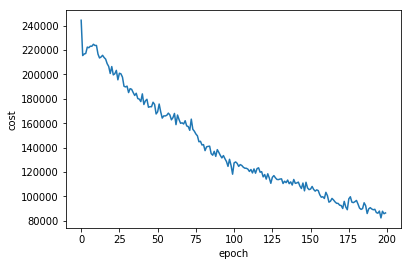

In [25]:
# Sample of the high level of variability in cost over time
tot_cost = costs1 + costs2 + costs3 + costs4 + costs5 + costs6 + costs7 + costs8
x_i = [i for i in range(len(tot_cost))]
plt.plot(x_i,tot_cost)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

In [26]:
costs9 = model(X_train,y_train,lr=0.000003,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 86525.29673184552
Cost at epoch 2: 91990.8313819531
Cost at epoch 3: 86838.74772970314
Cost at epoch 4: 86231.6522838966
Cost at epoch 5: 87799.0873574282
Cost at epoch 6: 88430.85301368913
Cost at epoch 7: 88905.67125740414
Cost at epoch 8: 82294.13593820996
Cost at epoch 9: 83096.29791467988
Cost at epoch 10: 82953.55658432088
Cost at epoch 11: 83885.85166217735
Cost at epoch 12: 85322.52329609654
Cost at epoch 13: 78829.84206722392
Cost at epoch 14: 82697.28952514596
Cost at epoch 15: 81124.75975895219
Cost at epoch 16: 82444.57300548791
Cost at epoch 17: 78331.37725162595
Cost at epoch 18: 80333.0718007786
Cost at epoch 19: 77802.05528428333
Cost at epoch 20: 78304.48200463547
Cost at epoch 21: 79197.73153370258
Cost at epoch 22: 73036.51991016795
Cost at epoch 23: 78456.7086958994
Cost at epoch 24: 76284.81688076326
Cost at epoch 25: 72784.36481810428


In [27]:
costs10 = model(X_train,y_train,lr=0.000001,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 85050.81070909106
Cost at epoch 2: 89382.38720774718
Cost at epoch 3: 82719.44066509616
Cost at epoch 4: 82099.74945766067
Cost at epoch 5: 83705.32212848685
Cost at epoch 6: 83599.97311815695
Cost at epoch 7: 84142.55287574779
Cost at epoch 8: 77168.5629822267
Cost at epoch 9: 77497.35228004547
Cost at epoch 10: 78420.97430570947
Cost at epoch 11: 79445.74538181676
Cost at epoch 12: 77847.81038818977
Cost at epoch 13: 72960.06256150319
Cost at epoch 14: 78000.44832428762
Cost at epoch 15: 76294.64650950112
Cost at epoch 16: 76499.6631421334
Cost at epoch 17: 72520.53846550873
Cost at epoch 18: 75321.05275057438
Cost at epoch 19: 71157.58716000488
Cost at epoch 20: 72337.11230785743
Cost at epoch 21: 72537.29971877273
Cost at epoch 22: 67392.68355499327
Cost at epoch 23: 70416.64142909217
Cost at epoch 24: 69184.44064181973
Cost at epoch 25: 65405.489570326914


In [28]:
costs11 = model(X_train,y_train,lr=0.0000003,num_epochs=25,retrain=True,print_each=False)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
Cost at epoch 1: 83704.9466106445
Cost at epoch 2: 88230.32426662542
Cost at epoch 3: 81140.36377629793
Cost at epoch 4: 80577.67984316956
Cost at epoch 5: 82287.97117895978
Cost at epoch 6: 82176.50073137603
Cost at epoch 7: 81040.92707000521
Cost at epoch 8: 74992.53674484702
Cost at epoch 9: 74374.59685685474
Cost at epoch 10: 75434.25937918876
Cost at epoch 11: 76361.86154997812
Cost at epoch 12: 74440.17598355774
Cost at epoch 13: 69094.69490133613
Cost at epoch 14: 74151.08844884994
Cost at epoch 15: 73193.87637183325
Cost at epoch 16: 72927.05609042195
Cost at epoch 17: 68394.33690808297
Cost at epoch 18: 71749.40457406295
Cost at epoch 19: 67936.18012879275
Cost at epoch 20: 68454.7509321934
Cost at epoch 21: 67891.14411036536
Cost at epoch 22: 63165.14147024098
Cost at epoch 23: 67624.63932353855
Cost at epoch 24: 65671.90158623955
Cost at epoch 25: 62002.10238568732


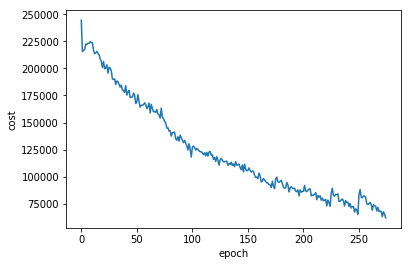

In [30]:
# Sample of the high level of variability in cost over time
tot_cost = costs1 + costs2 + costs3 + costs4 + costs5 + costs6 + costs7 + costs8 + costs9 + costs10 + costs11
x_i = [i for i in range(len(tot_cost))]
plt.plot(x_i,tot_cost)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

### Predicting using the model

In [52]:
# Getting a prediction for a particular input audio clip
ax = X_train[50]
ax.shape = (1,1402, 118)

tf.reset_default_graph() # computation graph to get binary predictions
x,y = get_placeholders()
out = rnn_cell(x)
pred = prediction(out)

saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../../data/trigger_word/model/trigger_model.ckpt.meta")
    saver.restore(sess, "../../data/trigger_word/model/trigger_model.ckpt")
    apred,adesc_pred = sess.run(pred,feed_dict={x:ax})
    print("descrete predictions:",adesc_pred)

INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt
descrete predictions: [[0 0 0 ... 0 0 0]]


In [53]:
act_y = y_train[50]
act_y.shape = (1375)
pred_y = adesc_pred
pred_y.shape = (1375)

In [56]:
f_name = "../../data/trigger_word/training/train61.wav"
IPython.display.Audio(f_name)

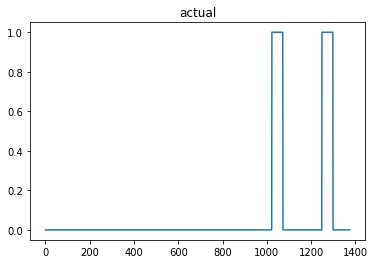

In [54]:
plt.plot(act_y)
plt.title("actual")
plt.show()

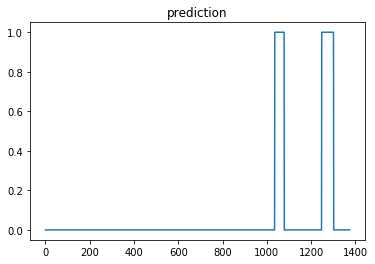

In [55]:
plt.plot(pred_y)
plt.title("prediction")
plt.show()

### Example of using this model to sample from a stream of audio

Given that this model takes in 10 second clips to make predictions, we will make this process semi-realtime by sampling audio every 0.5 seconds. This means that we will have a running 10 second clip with 0.5 seconds being shaved off the end and 0.5 seconds of new audio will be added to the beginning. We will then save 1/20 of the output to represent the next series of audio predictions.

In this example I will be using two clips to represent the first 10 seconds and then a stream of 20 0.5 second audio clips.

In [102]:
input1 = X_train[50]
input2 = X_train[50][0:1400,:] # removing 2 timesteps to make math easier
print(input1.shape)
print(input2.shape)

(1402, 118)
(1400, 118)


In [145]:
# Simulating a stream of audio data with predictions

tf.reset_default_graph() # computation graph to get binary predictions
x,y = get_placeholders()
out = rnn_cell(x)
pred = prediction(out)

no_iter = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../../data/trigger_word/model/trigger_model.ckpt.meta")
    saver.restore(sess, "../../data/trigger_word/model/trigger_model.ckpt")
    
    while(no_iter<21):
        if no_iter == 0: # predict the entire first 10 seconds
            ax = input1
            ax.shape = (1,1402, 118)
            apred,adesc_pred = sess.run(pred,feed_dict={x:ax})
            all_preds = adesc_pred[0].tolist() # used for saving the predicted labels
            no_iter += 1
            
        else: # simulating additional streaming data
            ax.shape = (1402,118)
            ax = np.concatenate((ax[70:,:],input2[70*(no_iter-1):70*no_iter,:])) # updating input to model
            ax.shape = (1,1402, 118)
            apred,adesc_pred = sess.run(pred,feed_dict={x:ax})
            all_preds += adesc_pred[:,1306:][0].tolist()
            no_iter += 1


INFO:tensorflow:Restoring parameters from ../../data/trigger_word/model/trigger_model.ckpt


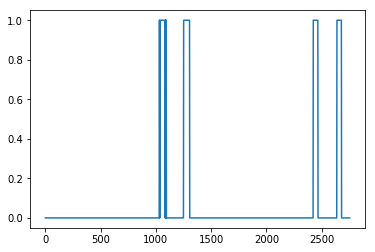

In [148]:
# This shows the stream of predictions, which aligns with the correct output
plt.plot(all_preds)
plt.show()